## Imports

In [2]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA
from tqdm import tqdm
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

from IPython.display import display

## Load Data

In [41]:
import seaborn as sns

In [148]:
data =  pd.read_csv('../processed_data/train_norm_rf_impute' , index_col = 0)
data = data.sample(frac=1)
data.head()

,class,src_n,src_id,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,...,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
index,,,,,,,,,,,,,,,,,,,,,
374,BH,CXOU J100516.5-07420,BH0021,16.75,0.421983,0.265998,0.374105,0.285124,0.376087,0.508522,...,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
384,NS,1H 1715-321,NS0006,2.32,0.362472,0.143688,0.321139,0.327079,0.354551,0.397773,...,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
340,NS,XMMU J004245.2+41172,NS0044,49.26,0.581535,0.564837,0.459609,0.482601,0.508970,0.506873,...,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
347,NS,XMMU J004245.2+41172,NS0046,4.71,0.000000,0.000000,0.000000,0.297861,0.270747,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
390,NS,EXO 0748-676,NS0019,62.80,0.987476,0.752587,0.871005,0.705780,0.880134,0.993440,...,0.348741,0.34715,0.345176,0.00372,0.010279,0.004635,0.009735,0.008754,0.009418,0.060298


In [149]:
info_col = [ 'class' , 'src_n' , 'src_id' , 'significance']
data_info = data[info_col]
data_val = data.drop(columns=info_col) 
data_label = data['class']

In [150]:
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier 
clf = RandomForestClassifier()

# PCA

### Acc Function

In [151]:
def acc_df(train_scores , valid_scores , param_range, n_dim):
    df = pd.DataFrame(train_scores)
    df.insert(0 , 'num_trees' , param_range)
    df = df.set_index('num_trees')
    df_train = df.stack().reset_index().drop(columns=['level_1']).set_index('num_trees')
    df_train.columns = ['acc_val']
    df_train.insert(1 , 'acc_type' , ['train_acc']*len(df_train))
    df_train.insert(0 , 'n_dim' , [n_dim]*len(df_train))
    df_train

    df = pd.DataFrame(valid_scores)
    df.insert(0 , 'num_trees' , param_range)
    df = df.set_index('num_trees')
    df_test = df.stack().reset_index().drop(columns=['level_1']).set_index('num_trees')
    df_test.columns = ['acc_val']
    df_test.insert(1 , 'acc_type' , ['test_acc']*len(df_test))
    df_test.insert(0 , 'n_dim' , [n_dim]*len(df_test))
    df_test
    acc = pd.concat([df_train , df_test] , axis=0).reset_index()
    return acc

In [152]:
def pca_wrap(param_name , param_range , n_dim = 10 , ):
    np.random.seed(29832)
    indices = np.arange(data_label.shape[0])
    if(n_dim < data_val.shape[1]):
        data_pca = PCA(n_components=n_dim , whiten=True ).fit_transform(data_val)
    else : data_pca = data_val.copy().values
    X, y = data_pca[indices], data_label.iloc[indices]
    train_scores, valid_scores = validation_curve(clf, X, y, param_name=param_name, param_range=param_range,cv=5)
    acc = acc_df(train_scores , valid_scores, param_range , n_dim)
    return acc


In [153]:
n_tree_range=np.arange(100,500 , 150)
n_dim_range = np.linspace(1.1,1.325 , num=16)**16
n_dim_range = [int(ti) for ti in n_dim_range ]
n_dim_range= np.append(n_dim_range[:-1],92)
n_dim_range= np.append(n_dim_range[:],6)
print(n_dim_range[:])
print(n_tree_range[:])
acc_02 = []

for pi in tqdm(n_dim_range):
    acc_02.append(pca_wrap('n_estimators' , n_tree_range , pi)) 



[ 4  5  7  8 10 13 16 19 24 29 35 42 51 62 75 92  6]
[100 250 400]


  0%|          | 0/17 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [65]:
acc_all_02 = pd.concat(acc_02).reset_index(drop=True)
acc_all_02.insert(2 , 'impute_type' , ['Median_impute']*len(acc_all_02))
acc_all_02

,num_trees,n_dim,impute_type,acc_val,acc_type
0,100,4,Median_impute,1.000000,train_acc
1,100,4,Median_impute,1.000000,train_acc
2,100,4,Median_impute,1.000000,train_acc
3,100,4,Median_impute,1.000000,train_acc
4,100,4,Median_impute,1.000000,train_acc
...,...,...,...,...,...
505,400,6,Median_impute,0.804348,test_acc
506,400,6,Median_impute,0.891304,test_acc
507,400,6,Median_impute,0.869565,test_acc
508,400,6,Median_impute,0.891304,test_acc


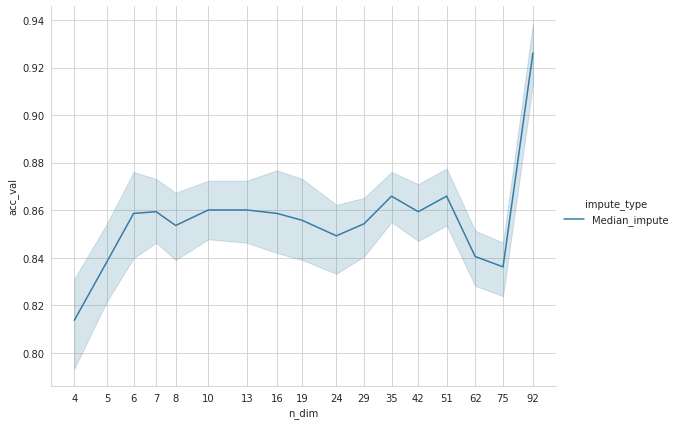

In [67]:
#sns.set_theme('paper')
sns.set_style('whitegrid')
colors = sns.color_palette('mako' ,n_colors=1)
#colors = sns.diverging_palette(240, 10, s=80, l=55, n=2 , center='dark')
to_plot = acc_all_02[acc_all_02['acc_type']=='test_acc']
to_plot = to_plot[to_plot['impute_type'].isin(['Median_impute'])]
#to_plot = to_plot[to_plot['num_trees']>10]
acc_plot = sns.relplot(
    data = to_plot , kind='line' , 
    x = 'n_dim' , y = 'acc_val' , 
    hue = 'impute_type' ,
    height = 6 , aspect = 8/6,
    color = 'crest',
    #alpha=0.1
    palette= colors
)
acc_plot.set(xscale='log')
#acc_plot.set(yscale='log')
acc_plot.set(xticks=n_dim_range)
acc_plot.set(xticklabels=n_dim_range)
#plt.title('Perfomance on Lower decomposed dim')
#plt.ylabel('Test Accuracy')
#plt.xlabel('Dimensions')
#plt.savefig('result/pca_dim_plot.png')
plt.show()

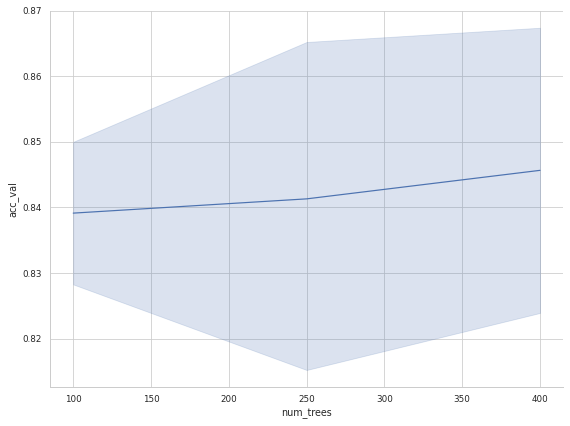

In [20]:
sns.set_theme('paper')
sns.set_style('whitegrid')
palette = sns.color_palette("mako_r", 4)
to_plot = acc_all[acc_all['acc_type']=='test_acc']
to_plot = to_plot[to_plot['n_dim']==7]
acc_plot = sns.relplot(
    data = to_plot , kind='line' , 
    x = 'num_trees' , y = 'acc_val' , 
    #hue = 'num_trees' ,
    height = 6 , aspect = 8/6,
    palette='copper'
)
#acc_plot.set(xscale='log')
#acc_plot.set(yscale='log')
#acc_plot.set(xticks=n_dim_range)
#acc_plot.set(xticklabels=n_dim_range)
plt.show()

# Hyper Parameter Tuning

In [154]:
rfc_v2 = RandomForestClassifier()

## Random Search

In [155]:
from sklearn.model_selection import RandomizedSearchCV

In [156]:
n_estimators = [int(x) for x in np.linspace(80 , 450 , num=40)]
max_features = ['log2' , 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 150, num = 40)]
min_samples_split = [int(x) for x in np.linspace(2,20 ,num = 30)]
min_samples_leaf = [int(x) for x in np.linspace(2,30 , num = 30)]
bootstrap = [True , False]

In [157]:
params_dict = {
    'n_estimators' : n_estimators , 
    'max_features' : max_features ,
    'max_depth' :max_depth , 
    'min_samples_split' : min_samples_split , 
    'min_samples_leaf' : min_samples_leaf, 
    'bootstrap' : bootstrap 
}

In [158]:
rs = RandomizedSearchCV(
    rfc_v2 , 
    params_dict , 
    n_iter = 200,
    cv = 5 ,
    verbose = 5 ,
    n_jobs=-1 , 
    random_state= 0 
)

In [159]:
rs.fit(data_val , data_label)
rs.best_params_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


{'n_estimators': 136,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 27,
 'bootstrap': False}

In [160]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,split3_test_score,split4_test_score,mean_test_score,rank_test_score
0,136,2,2,sqrt,27,False,0.967391,0.934783,0.930435,1
1,222,2,2,sqrt,85,False,0.956522,0.934783,0.923913,2
2,89,18,6,sqrt,69,False,0.978261,0.934783,0.921739,3
3,402,7,2,sqrt,146,False,0.945652,0.934783,0.921739,3
4,117,7,2,sqrt,127,True,0.967391,0.923913,0.921739,3
5,307,5,4,sqrt,77,False,0.956522,0.934783,0.919565,6
6,421,8,2,sqrt,20,True,0.967391,0.934783,0.919565,7
7,146,10,6,sqrt,46,False,0.967391,0.934783,0.919565,7
8,402,16,4,sqrt,12,False,0.956522,0.934783,0.917391,9
9,260,3,2,sqrt,46,True,0.945652,0.934783,0.917391,10


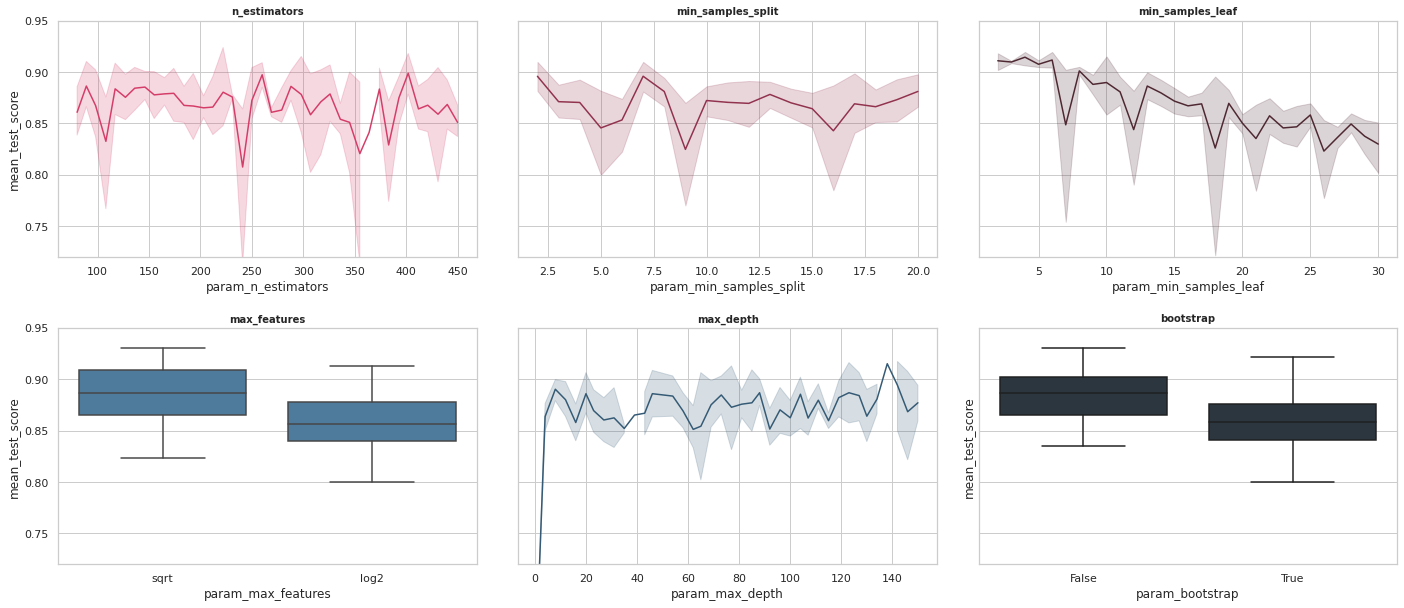

In [161]:
sns.set(style="whitegrid", color_codes=True, font_scale = 1)
fig, axs = plt.subplots(ncols=3, nrows=2  , sharey=True)
fig.set_size_inches(24,10)
colors = sns.diverging_palette(240, 0, n=6 , center='dark')
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0],color=colors[5]) 
axs[0,0].set_ylim([.72,.95])
axs[0,0].set_title(label = 'n_estimators', size=10, weight='bold')
sns.lineplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1],color=colors[4])
#axs[0,1].set_ylim([.85,.93])
axs[0,1].set_title(label = 'min_samples_split', size=10, weight='bold')
sns.lineplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2],color=colors[3])
#axs[0,2].set_ylim([.80,.93])
axs[0,2].set_title(label = 'min_samples_leaf', size=10, weight='bold')
sns.boxplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0],color=colors[0])
#axs[1,0].set_ylim([.88,.92])
axs[1,0].set_title(label = 'max_features', size=10, weight='bold')
sns.lineplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1],color=colors[1])
#axs[1,1].set_ylim([.80,.93])
axs[1,1].set_title(label = 'max_depth', size=10, weight='bold')
sns.boxplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2] , color=colors[2])
#axs[1,2].set_ylim([.88,.92])
axs[1,2].set_title(label = 'bootstrap', size=10, weight='bold')
fig.subplots_adjust(wspace=0.1 , hspace=0.3)

plt.show()


### Result
> Best Model Parameters
```

{'n_estimators': 136,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 27,
 'bootstrap': False}
```
> Best Parameter values

```
{'n_estimators': [136 , 309 , 347,385],
 'min_samples_split': [7,12,44],
 'min_samples_leaf': [2,7,12],
 'max_features': 'sqrt',
 'max_depth': [43 ,85, 100],
 'bootstrap': False}
```

## Grid Search

In [81]:
from sklearn.model_selection import GridSearchCV

In [78]:
n_estimators = [140 , 170 , 230]
max_features = ['sqrt'] 
bootstrap = [False]
max_depth =  [56 ,85, 100]
min_samples_leaf = [2,12]
min_samples_split = [7,18,28]

In [82]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [85]:
gs = GridSearchCV(rfc_v2 , param_grid , cv=5 , verbose=5 , n_jobs=-1)
gs.fit(data_val , data_label)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [56, 85, 100],
                         'max_features': ['sqrt'], 'min_samples_leaf': [2, 12],
                         'min_samples_split': [7, 18, 28],
                         'n_estimators': [140, 170, 230]},
             verbose=5)

In [86]:
gs.best_params_

{'bootstrap': False,
 'max_depth': 56,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 140}

# Comparison

### Train-test split

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cf 
from sklearn.ensemble import RandomForestClassifier

In [20]:
data =  pd.read_csv('processed_data/train_norm_rf_impute' , index_col = 0)
np.random.seed(433)
data = data.sample(frac=1).reset_index(drop=True)
split = int(0.8*(len(data)))
info_col = [ 'class' , 'src_n' , 'src_id' , 'significance']
data_info = data[info_col]
data_val = data.drop(columns=info_col) 
data_label = data['class']
x = data_val.copy()
y = data_label.copy()
x_train, x_test , y_train , y_test = x_train , x_test , y_train , y_test = train_test_split(x,y , test_size=0.2 , stratify=y)

### Monte Carlo Cross Validation 

In [5]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
def mc_validation(model_func , x  , y , model_name = '' , pca=False):
    train_acc = []
    test_acc = []

    for i in tqdm(range(32)):
        x_train , x_test , y_train , y_test = train_test_split(x,y , test_size=0.2)
        if(pca):
            pca = PCA(n_components=7)
            x_train = pca.fit_transform(x_train)
            x_test = pca.transform(x_test)
        clf = model_func
        clf.fit(x_train , y_train)
        #print('train , test' , y_train.shape , y_test.shape)
        #print(clf.score(x_test, y_test))
        test_acc.append(clf.score(x_test , y_test))
        train_acc.append(clf.score(x_train , y_train))

    acc_train =  pd.DataFrame()
    acc_test = pd.DataFrame()

    
    acc_test.insert(0 , 'acc_type' , ['Test_acc']*len(train_acc))
    acc_test.insert(1 , 'accuracy' , test_acc)
    acc_test = acc_test.reset_index(drop=True)
   
    acc_train.insert(0 , 'acc_type' , ['Train_acc']*len(train_acc))
    acc_train.insert(1 , 'accuracy' , train_acc)
    acc_train = acc_train.reset_index(drop=True)

    acc = pd.concat([acc_train , acc_test]).reset_index(drop=True)
    acc.insert(0 , 'model' , [model_name]*len(acc))
    return acc


## Vanilla RF

In [6]:
rf_vanila = RandomForestClassifier(n_estimators=300)
rf_vanila.fit(x_train , y_train)
y_pred_vanila = rf_vanila.predict(x_test)
cf_vanila = cf(y_test , y_pred_vanila)
print(cf_vanila) 

[[27  5]
 [ 5 55]]


In [7]:
rf_vanila.score(x_test, y_test)

0.8913043478260869

In [8]:
print(y_train.shape , y_test.shape)

(368,) (92,)


In [9]:
acc_vanila = mc_validation(rf_vanila , data_val , data_label, model_name='Vanila_RF').reset_index(drop=True)


100%|██████████| 32/32 [00:24<00:00,  1.28it/s]


In [10]:
acc_vanila.to_csv('result/acc_vanila.csv')
acc_vanila

,model,acc_type,accuracy
0,Vanila_RF,Train_acc,1.000000
1,Vanila_RF,Train_acc,1.000000
2,Vanila_RF,Train_acc,1.000000
3,Vanila_RF,Train_acc,1.000000
4,Vanila_RF,Train_acc,1.000000
...,...,...,...
59,Vanila_RF,Test_acc,0.913043
60,Vanila_RF,Test_acc,0.869565
61,Vanila_RF,Test_acc,0.956522
62,Vanila_RF,Test_acc,0.923913


## Vanilla RF with PCA

In [95]:
from sklearn.decomposition import PCA

In [96]:
pca = PCA(n_components=7 ,svd_solver='full' , random_state=2)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

rf_van_pca = RandomForestClassifier(n_estimators=300)
rf_van_pca.fit(x_train_pca , y_train)
y_pred_van_pca = rf_van_pca.predict(x_test_pca)
cf_van_pca = cf(y_test , y_pred_van_pca)
print(cf_van_pca) 

[[23  9]
 [ 8 52]]


In [97]:
acc_vanila_pca = mc_validation(rf_van_pca , data_val , data_label ,model_name = 'vanila_rf_PCA' ,  pca=True ,).reset_index(drop=True)

100%|██████████| 32/32 [00:23<00:00,  1.39it/s]


In [98]:
acc_vanila_pca.to_csv('result/acc_vanila_pca.csv')

## Tuned RF

{'n_estimators': 345,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 43,
 'bootstrap': False}

In [127]:
rf_t = RandomForestClassifier(n_estimators=340 ,
        min_samples_split = 5 ,
        min_samples_leaf = 2 , 
        max_depth = 43 , 
        bootstrap=False , 
        max_features = 'sqrt',
        )
rf_t.fit(x_train , y_train)


RandomForestClassifier(bootstrap=False, max_depth=43, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=340)

In [128]:

y_pred_t = rf_t.predict(x_test)
cf_t = cf(y_test , y_pred_t)
(cf_t)

array([[27,  5],
       [ 3, 57]])

In [129]:
acc_tuned = mc_validation(rf_t , data_val , data_label, model_name='Tuned_RF').reset_index(drop=True)
acc_tuned.to_csv('result/acc_tuned.csv')
acc_tuned

100%|██████████| 32/32 [00:27<00:00,  1.15it/s]


,model,acc_type,accuracy
0,Tuned_RF,Train_acc,1.000000
1,Tuned_RF,Train_acc,1.000000
2,Tuned_RF,Train_acc,1.000000
3,Tuned_RF,Train_acc,1.000000
4,Tuned_RF,Train_acc,1.000000
...,...,...,...
59,Tuned_RF,Test_acc,0.934783
60,Tuned_RF,Test_acc,0.847826
61,Tuned_RF,Test_acc,0.902174
62,Tuned_RF,Test_acc,0.902174


## Result

In [119]:
acc_vanila = pd.read_csv('result/acc_vanila.csv')
acc_tuned = pd.read_csv('result/acc_tuned.csv')
acc_vanila_pca = pd.read_csv('result/acc_vanila_pca.csv')

In [120]:
acc = acc_vanila.copy()
display(acc[acc['acc_type'] == 'Test_acc'][['accuracy']].describe().head(3))
acc = acc_vanila_pca.copy()
display(acc[acc['acc_type'] == 'Test_acc'][['accuracy']].describe().head(3))
acc = acc_tuned.copy()
display(acc[acc['acc_type'] == 'Test_acc'][['accuracy']].describe().head(3))

,accuracy
count,32.000000
mean,0.921196
std,0.028155


,accuracy
count,32.000000
mean,0.827446
std,0.041574


,accuracy
count,32.000000
mean,0.926291
std,0.029957


In [121]:
acc = pd.concat([acc_vanila, acc_vanila_pca , acc_tuned]).reset_index(drop=True)
acc.to_csv('result/acc_sklearn_rf_all.csv')

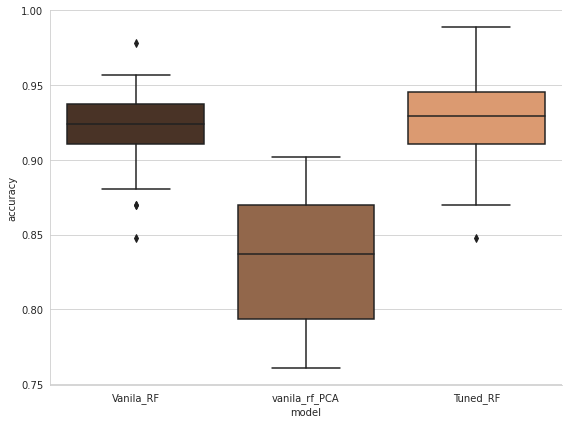

In [122]:
sns.set_style('whitegrid')
pal = sns.diverging_palette(240, 10, s=80, l=55, n=3)
acc = pd.read_csv('result/acc_sklearn_rf_all.csv')
sns.catplot(data = acc[acc['acc_type']=='Test_acc'] , y='accuracy' , x = 'model' ,
            kind='box' ,  # hue='acc_type',
            palette = 'copper' , 
            height=6 , aspect=8/6
            )
plt.savefig('result/param_tuning_res_box.jpg')
plt.show()

# Best Random Forest

So Now we have identified best random Forest , lets see how its various performance are.

## Load Data

In [4]:
#data_all =  pd.read_csv('../processed_data/train_none_rf_impute' , index_col = 'obs_id')
data_all =  pd.read_csv('../processed_data/train_norm_median' , index_col = 'obs_id')
np.random.seed(433)
data = data_all.sample(frac=1).reset_index(drop=True)
data_label = data['class']
x = data.copy().reset_index(drop=True)
brems_model = ['brems_nh' , 'brems_nh_lolim' , 'brems_nh_hilim' , 'brems_kt' , 'brems_kt_lolim' , 'brems_kt_hilim']
inter_obs_param = ['var_inter_index' , 'var_inter_prob' , 'var_inter_sigma']
x = x.drop(columns= brems_model)
y = data_label.copy().reset_index(drop=True)


## Train and save model

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
{'n_estimators': 136,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 27,
 'bootstrap': False}

In [5]:
train_acc = []
test_acc = []
best_clf = ''
score = 0 
for i in tqdm(range(1)):
    rs = int(np.random.uniform(10 , 99999))
    #rs = 61921
    rs= 16683
    #rs= 961
    np.random.seed(rs)
    df =  x.sample(frac=1 , random_state=rs)
    y = df['class']
    x_train , x_test , _ , _ = train_test_split(df , y , test_size=0.2 , shuffle=True, random_state=10 , stratify=y)
    info_col = ['src_n' , 'src_id' , 'significance' , 'class']
    id_train = x_train[info_col]
    id_test = x_test[info_col]
    y_train = x_train['class']
    y_test = x_test['class']
    x_train = x_train.drop(info_col , axis=1)
    x_test = x_test.drop(info_col , axis = 1 )
    #np.random.seed(5926)
    clf = RandomForestClassifier(
        n_estimators= 140 , 
        criterion='entropy' ,
        random_state=12,
        max_depth=56 , 
        min_samples_leaf= 2 , 
        min_samples_split=7 , 
        bootstrap=False ,
        max_features='sqrt' ,
        class_weight='balanced'
        )
    clf.fit(x_train , y_train)
    tr = clf.score(x_train , y_train)
    next_score = clf.score(x_test , y_test)
    if(next_score > score):
        best_clf = clf
        score = next_score
        print('better found' , rs , next_score)
    #print(next_score , score)
    #print('\n -----------------')
    #print(rs , tst)
    ##train_acc.append(tr)
    #test_acc.append(tst)

100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

better found 16683 0.9130434782608695


In [6]:
test_score =  best_clf.score(x_test , y_test)
print(test_score)

0.9130434782608695


## Feature Importace

In [7]:
feat_imp = clf.feature_importances_
feat_names = x_train.columns.to_list()
feat = pd.DataFrame()
feat.insert( 0 , 'feat_name' , feat_names)
feat.insert(1 , 'feat_imp' , feat_imp)
feat = feat.sort_values(by = 'feat_imp' , ascending=False).reset_index(drop=True)
feat_names_sorted = feat['feat_name']
display(feat)
feat.to_csv('result/feat_imp_median.csv')

,feat_name,feat_imp
0,var_inter_index,0.158498
1,var_inter_prob,0.113650
2,var_inter_sigma,0.045066
3,photflux_aper_hilim_u,0.037184
4,flux_aper_hilim_u,0.035750
...,...,...
81,flux_bb,0.000293
82,bb_nh_lolim,0.000273
83,flux_brems_hilim,0.000089
84,flux_powlaw,0.000076


## Bake Result

### Function

In [8]:
def create_res_data(x , y , id_data  , cl_type):
    pred = clf.predict(x)
    pred_prob = np.asarray(clf.predict_proba(x))
    pred_prob_bh = pred_prob[:,0]
    pred_prob_ns = pred_prob[:,1]
    pred_prob = [np.amax(pi) for pi in pred_prob]

    res =  x.reset_index(drop=True)
    res = res[feat_names_sorted]
    #display(res)
    id_data = id_data.reset_index(drop=True)
    #display(id_data)
    #display(res)
    res.insert(0 , 'clf_type' , [cl_type]*len(res))
    #res.insert(0 , 'src_id' , id)
    #res.insert(1, 'src_n' , n)
    res.insert(1 , 'true_class' , y.reset_index(drop=True))
    res.insert(2 ,'pred_class' , pred)
    res.insert(3 , 'pred_prob' , pred_prob)
    res.insert(4 , 'BH_prob' , pred_prob_bh)
    res.insert(5 , 'NS_prob' , pred_prob_ns)
    res = pd.concat([id_data , res] , axis=1).drop('class' , axis=1)
    truth = []
    th_class = [] 
    is_ok = [] 
    for tc , pc , pp in zip(res['true_class'] , res['pred_class'] , res['pred_prob']):
        if(tc==pc): is_ok.append(1)
        else: is_ok.append(0)
        if(pp > 0.80):
            th_class.append(pc)
            if(tc==pc):
                truth.append(1)
            else: truth.append(0)
        else :
            truth.append(2)
            th_class.append('X')
    res.insert(5 , 'th_class' , th_class )
    res.insert(6 , 'truth' , truth)
    res.insert(6 , 'is_ok' , is_ok)
    #display(res)
    return res


### Bake it

In [9]:

train_res = create_res_data(x_train , y_train ,id_train , cl_type='train').reset_index(drop=True)
test_res = create_res_data(x_test , y_test ,id_test , cl_type='test').reset_index(drop=True)
#train_res.to_csv('result/train_res_rf.csv')
#test_res.to_csv('result/test_res_rf.csv')
res_data = pd.concat([train_res , test_res]).reset_index(drop=True)
#res_data =  res_data.set_index('obs_id')
res_data.to_csv('result/res_rf_tuned_median.csv')
res_data

,src_n,src_id,significance,clf_type,true_class,th_class,is_ok,truth,pred_class,pred_prob,...,powlaw_nh_lolim,powlaw_stat,flux_bb_hilim,flux_brems,flux_brems_lolim,flux_bb,bb_nh_lolim,flux_brems_hilim,flux_powlaw,flux_bb_lolim
0,SAXWFC J1744.9-2921.,NS0068,9.04,train,NS,NS,1,1,NS,0.976742,...,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946
1,XMMU J004245.2+41172,NS0044,49.26,train,NS,NS,1,1,NS,1.000000,...,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946
2,1WGA J0748.5-6745,NS0076,6.77,train,NS,NS,1,1,NS,0.873099,...,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946
3,J1745-2900,BH0027,337.00,train,BH,BH,1,1,BH,0.983485,...,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946
4,SAXWFC J1748.1-2446.,NS0072,19.47,train,NS,NS,1,1,NS,0.991019,...,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,SAXWFC J1748.1-2446.,NS0071,2.75,test,NS,NS,1,1,NS,0.919775,...,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946
456,SAX J1819.3-2525,BH0009,26.51,test,BH,X,1,2,BH,0.720705,...,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946
457,SAXWFC J1744.9-2921.,NS0068,9.04,test,NS,NS,1,1,NS,0.957334,...,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946
458,H 1658-298,NS0024,31.12,test,NS,X,0,2,BH,0.527134,...,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946,0.391946
